In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
import os


folder_name = 'AREADNE_Poster' 
os.makedirs(folder_name, exist_ok=True)



def save_figure(figure_name, facecolor=None, transparent=True):
    figure_name = os.path.join(folder_name, figure_name)
    if facecolor is None:
        plt.savefig(f'{figure_name}.pdf', transparent=transparent,
                    dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f'{figure_name}.pdf', transparent=transparent,
                    dpi=300, bbox_inches='tight', facecolor=facecolor)
    plt.savefig(f'{figure_name}.png', transparent=transparent,
                dpi=300, bbox_inches='tight')

In [3]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np
from scipy.stats import multivariate_normal


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]

    node_positions2 = [(80, 40),
                       (0, 40),
                       (0, 80),
                       (80, 80),
                       (0, 0),
                       (80, 0),
                       ]
    edges = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]

    track_graph1 = make_track_graph(node_positions1, edges)
    track_graph2 = make_track_graph(node_positions2, edges)
    
    traversal_path = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0), (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path, track_graph1)
    position2 = generate_position(traversal_path, track_graph2)
    
    edge_order = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order,
                                           edge_spacing=edge_spacing,
                                           use_HMM=False)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order,
                                          edge_spacing=edge_spacing,
                                          use_HMM=False)
    
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    place_field_centers2 = generate_position(traversal_path, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)

    
    spikes2 = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    
    position1 += multivariate_normal(mean=[0.00, 0.00], cov=[[0.01, 0.0], [0.0, 0.01]]).rvs(size=len(position1))
    position2 += multivariate_normal(mean=[0.00, 0.00], cov=[[0.01, 0.0], [0.0, 0.01]]).rvs(size=len(position2))
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order, edge_spacing
           )

In [4]:
(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order, edge_spacing
) = make_two_environment_data()

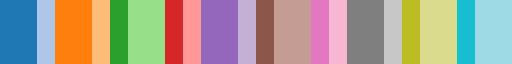

In [5]:
import matplotlib.colors

N = 28

segmented_cmap = matplotlib.colors.ListedColormap(
    plt.get_cmap('tab20')(np.linspace(0, 1, N)))

segmented_cmap

In [6]:
colors = np.asarray(["#609ed8",
"#3fbfbc",
"#d4a46d",
"#427d4a",
"#e5878e",
"#996733",
"#7c722b",
"#a2b367",
"#9e4a76",
"#d680b4",
"#ab4b54",
"#5f69b3",
"#5bbc89",
"#b28cdd",
"#e77f60",
"#5b8225",
"#a7432c",
"#b66221",
"#d4a038",
"#9a42a8",
"#d6418d",
"#db3e5b",
"#a3b734",
"#56ba50",
"#6d63d7",
"#e67e2d",
"#d96ad6",
"#d8492c"])

In [7]:

def plot_wtrack1_outline(ax=None, color='black'):
    if ax is None:
        ax = plt.gca()

    ax.plot([40 + 5, 40 + 5], [80 + 5, 0 + 5], color=color)
    ax.plot([40 - 5, 40 - 5], [80 + 5, 0 + 5], color=color)
    ax.plot([40 - 5, 40 + 5], [80 + 5, 80 + 5], color=color)

    ax.plot([0 + 5, 0 + 5], [80 + 5, 0 + 5], color=color)
    ax.plot([0 - 5, 0 - 5], [80 + 5, 0 - 5], color=color)
    ax.plot([0 - 5, 0 + 5], [80 + 5, 80 + 5], color=color)

    ax.plot([80 + 5, 80 + 5], [80 + 5, 0 - 5], color=color)
    ax.plot([80 - 5, 80 - 5], [80 + 5, 0 + 5], color=color)
    ax.plot([80 - 5, 80 + 5], [80 + 5, 80 + 5], color=color)

    ax.plot([0 - 5, 80 + 5], [0 - 5, 0 - 5], color=color)
    ax.plot([0 + 5, 40 - 5], [0 + 5, 0 + 5], color=color)
    ax.plot([40 + 5, 80 - 5], [0 + 5, 0 + 5], color=color)
    
    ax.text(0, 80 + 8, 'L', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(40, 80 + 8, 'C', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80, 80 + 8, 'R', fontweight='bold', fontsize=24, ha='center', va='center')
    
def plot_wtrack2_outline(ax=None, color='black'):
    if ax is None:
        ax = plt.gca()

    ax.plot([80 + 5, 0 + 5], [40 + 5, 40 + 5], color=color)
    ax.plot([80 + 5, 0 + 5], [40 - 5, 40 - 5], color=color)
    ax.plot([80 + 5, 80 + 5], [40 - 5, 40 + 5], color=color)

    ax.plot([80 + 5, 0 + 5], [0 + 5, 0 + 5], color=color)
    ax.plot([80 + 5, 0 - 5], [0 - 5, 0 - 5], color=color)
    ax.plot([80 + 5, 80 + 5], [0 - 5, 0 + 5], color=color)

    ax.plot([80 + 5, 0 - 5], [80 + 5, 80 + 5], color=color)
    ax.plot([80 + 5, 0 + 5], [80 - 5, 80 - 5], color=color)
    ax.plot([80 + 5, 80 + 5], [80 - 5, 80 + 5], color=color)

    ax.plot([0 - 5, 0 - 5], [0 - 5, 80 + 5], color=color)
    ax.plot([0 + 5, 0 + 5], [0 + 5, 40 - 5], color=color)
    ax.plot([0 + 5, 0 + 5], [40 + 5, 80 - 5], color=color)
    
    ax.text(80 + 8, 0, 'R', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80 + 8, 40, 'C', fontweight='bold', fontsize=24, ha='center', va='center')
    ax.text(80 + 8, 80, 'L', fontweight='bold', fontsize=24, ha='center', va='center')

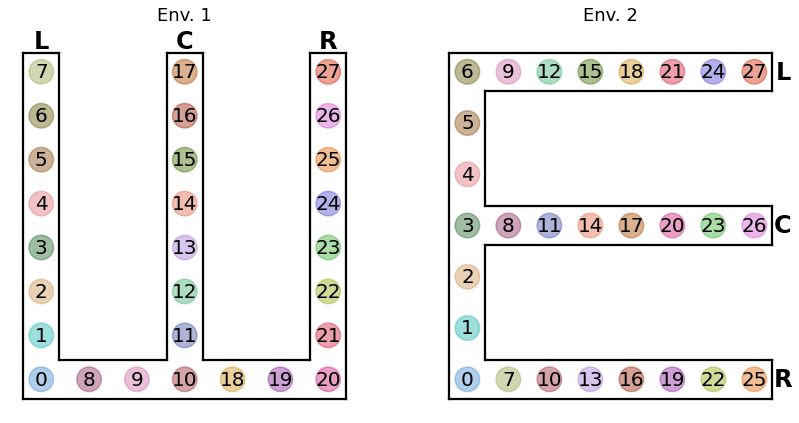

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0.5, s=600, zorder=0, color=colors)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[0].set_title('Env. 1', pad=15)
axes[0].set_ylabel('Y-Position')
axes[0].set_xlabel('X-Position')
plot_wtrack1_outline(ax=axes[0])
axes[0].axis('off')
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0.5, s=600, zorder=0, color=colors)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[1].set_title('Env. 2', pad=15)
axes[1].set_xlabel('X-Position')
plot_wtrack2_outline(ax=axes[1])
axes[1].axis('off');
# save_figure('env_with_cell_numbers_alt')

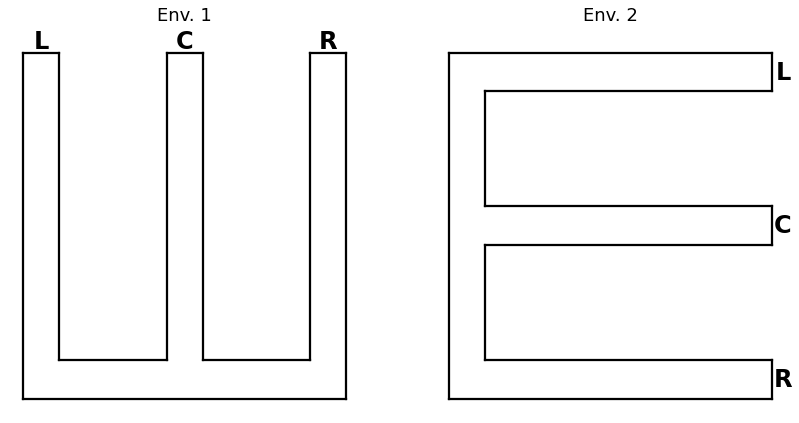

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].set_title('Env. 1', pad=15)
axes[0].set_ylabel('Y-Position')
axes[0].set_xlabel('X-Position')
plot_wtrack1_outline(ax=axes[0])
axes[0].axis('off')
# save_figure('')
    
axes[1].set_title('Env. 2', pad=15)
axes[1].set_xlabel('X-Position')
plot_wtrack2_outline(ax=axes[1])
axes[1].axis('off');
# save_figure('envs')

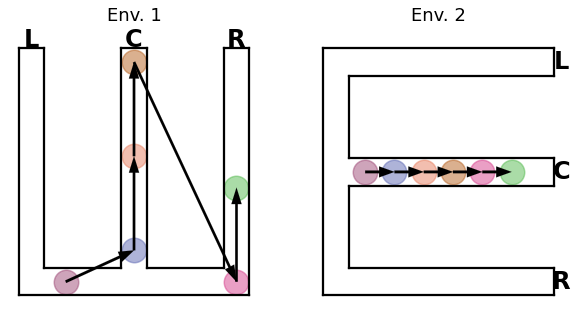

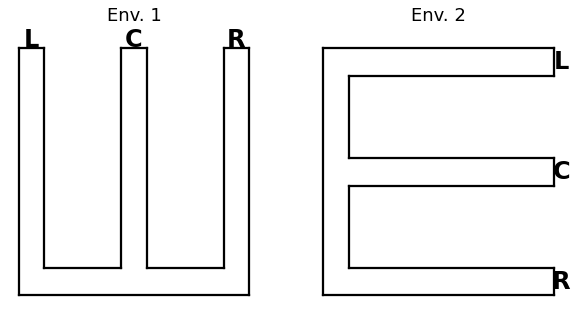

In [9]:
def plot_2D_place_field_sequence(sequence):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ind, center in enumerate(place_field_centers1):
        if ind in sequence:
            axes[0].scatter(place_field_centers1[ind, 0], place_field_centers1[ind, 1], alpha=0.5, s=600, zorder=0, color=colors[ind])
    
    for ind1, ind2 in zip(sequence[:-1], sequence[1:]):
        axes[0].arrow(place_field_centers1[ind1, 0],
                      place_field_centers1[ind1, 1],
                      place_field_centers1[ind2, 0] - place_field_centers1[ind1, 0],
                      place_field_centers1[ind2, 1] - place_field_centers1[ind1, 1],
                      width=1,
                      head_width=4,
                      alpha=1,
                      color='black',
                      zorder=1,
                      linewidth=0.1,
                      length_includes_head=True
                     )
        
    axes[0].set_title('Env. 1', pad=15)
    axes[0].axis('off')
    plot_wtrack1_outline(ax=axes[0])

    for ind, center in enumerate(place_field_centers2):
        if ind in sequence:
            axes[1].scatter(place_field_centers2[ind, 0], place_field_centers2[ind, 1], alpha=0.5, s=600, zorder=0, color=colors[ind])
        
    for ind1, ind2 in zip(sequence[:-1], sequence[1:]):
        axes[1].arrow(place_field_centers2[ind1, 0],
                      place_field_centers2[ind1, 1],
                      place_field_centers2[ind2, 0] - place_field_centers2[ind1, 0],
                      place_field_centers2[ind2, 1] - place_field_centers2[ind1, 1],
                      width=1,
                      head_width=4,
                      alpha=1,
                      color='black',
                      zorder=1,
                      linewidth=0.1,
                      length_includes_head=True
                     )
    axes[1].set_title('Env. 2', pad=15)
    axes[1].axis('off')
    plot_wtrack2_outline(ax=axes[1])
    sns.despine()
    
sequence = [8, 11, 14, 17, 20, 23]
plot_2D_place_field_sequence(sequence)

sequence = []
plot_2D_place_field_sequence(sequence)

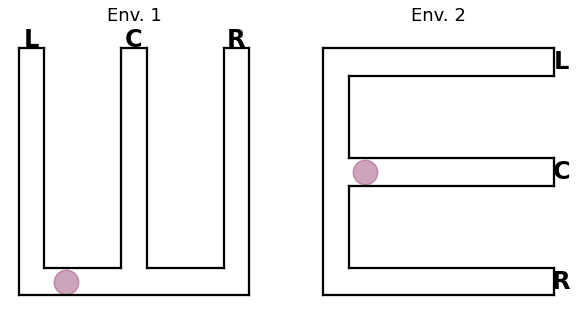

In [11]:
sequence = [8]
plot_2D_place_field_sequence(sequence)

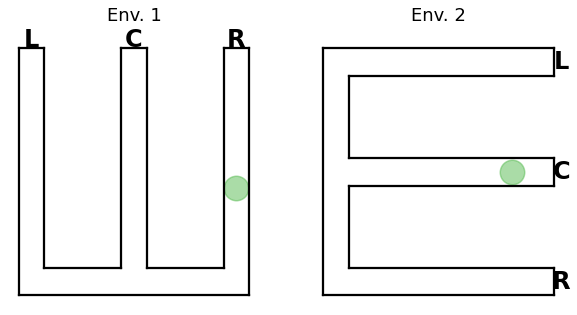

In [12]:
sequence = [23]
plot_2D_place_field_sequence(sequence)

In [10]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform
from replay_trajectory_classification.observation_model import ObservationModel

environments = (
    Environment('wtrack1', dilate=True),
    Environment('wtrack2', dilate=True))

movement_var = 12.0

continuous_transition_types = [[RandomWalk('wtrack1', movement_var=movement_var, use_diffusion=True),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2', movement_var=movement_var, use_diffusion=True)]]

environment_names_to_state = ['wtrack1', 'wtrack2']
observation_models = [ObservationModel('wtrack1'), ObservationModel('wtrack2')]

classifier = SortedSpikesClassifier(
    environments=environments,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
    sorted_spikes_algorithm_params={'block_size': None,
                                   'position_std': 6.0,
                                   'use_diffusion_distance': True}
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=12.0, movement_mean=0.0, use_diffusion=True),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=12.0, movement_mean=0.0...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=[ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack2', encoding_group=0)],
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_algorithm_params={'block

In [11]:
position = np.concatenate((position1,
                           position2))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack1'] * spikes1.shape[0],
                                     ['wtrack2'] * spikes2.shape[0],
                                    ))
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=12.0, movement_mean=0.0, use_diffusion=True),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=12.0, movement_mean=0.0...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=[ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack2', encoding_group=0)],
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_algorithm_params={'block

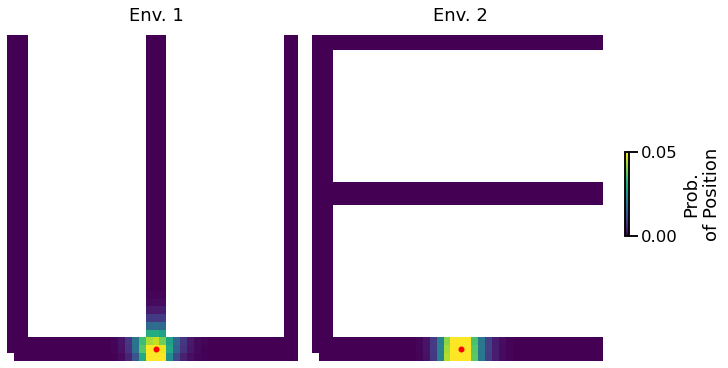

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

vmax = 0.05

for env_ind, (ax, env) in enumerate(zip(axes.flat, classifier.environments)):
    mask = ~env.is_track_interior_
    mask = mask.astype(float)
    mask[mask == 1] = np.nan
    mask[mask == 0] = 1

    bin_ind = np.nonzero(env.is_track_interior_.ravel(order="F"))[0][62]
    state_transition = (
        classifier
        .continuous_state_transition_[env_ind, env_ind, bin_ind]
        .reshape(env.centers_shape_, order='F'))

    mesh = ax.pcolormesh(env.edges_[0],
                  env.edges_[1],
                  state_transition.T * mask.T, vmin=0.0, vmax=vmax)
    ax.scatter(env.place_bin_centers_[bin_ind, 0],
               env.place_bin_centers_[bin_ind, 1], color='red', zorder=10, s=20)
    # if env_ind == 0:
    #     plot_wtrack1_outline(ax=ax)
    # else:
    #     plot_wtrack2_outline(ax=ax)
    ax.set_title(f'Env. {env_ind + 1}')
    ax.axis('off')

plt.colorbar(mappable=mesh, ax=ax, shrink=0.25, ticks=[0.0, vmax], label='Prob.\nof Position')
save_figure('diffusion_continuous_transition')

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x1000 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y diffusion.mp4


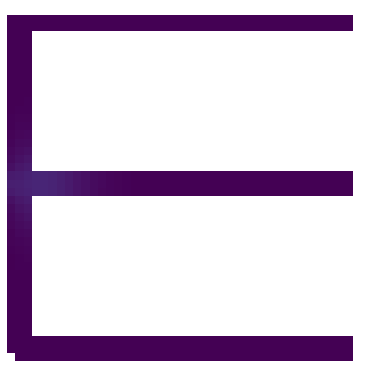

In [16]:
from replay_trajectory_classification.environments import diffuse
import matplotlib.animation as animation


fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
env_ind = 0
env = classifier.environments[env_ind]

mask = ~env.is_track_interior_
mask = mask.astype(float)
mask[mask == 1] = np.nan
mask[mask == 0] = 1
is_track_interior = env.is_track_interior_
is_track_boundary = env.is_track_boundary_
dx = (env.edges_[0][1] -
      env.edges_[0][0])
dy = (env.edges_[1][1] -
      env.edges_[1][0])
bins_shape = is_track_interior.shape

ind = 62

x_inds, y_inds = np.nonzero(is_track_interior)

std = np.sqrt(64)
alpha=0.5
dt = 0.25 / (alpha / dx**2 + alpha / dy**2)
Fx = alpha * (dt / dx**2)
Fy = alpha * (dt / dy**2)

T = std**2 / (2 * alpha)
n_time = int((T // dt) + 1)

position_grid = np.zeros(bins_shape)
position_grid[y_inds[ind], x_inds[ind]] = 1.0
ax.axis('off')
mesh = ax.pcolormesh(env.edges_[0], env.edges_[1], position_grid.T * mask.T, vmin=0.0, vmax=0.1)

def _update_plot(time_ind, position_grid):
    position_grid = diffuse(position_grid, Fx, Fy,
                            is_track_interior, is_track_boundary)
    mesh.set_array(
        (position_grid.T * mask.T).ravel(order="F")
    )
    return mesh,

fps = 30
Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, bitrate=-1)
movie = animation.FuncAnimation(fig, _update_plot, frames=n_time, fargs=(position_grid,),
                                interval=1000 / fps, blit=True)

movie.save('diffusion.mp4', writer=writer, dpi=200)

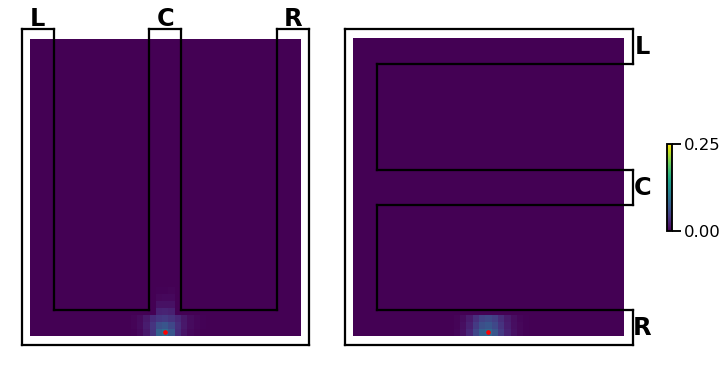

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for env_ind, (ax, env) in enumerate(zip(axes.flat, classifier.environments)):
    bin_ind = np.nonzero(env.is_track_interior_.ravel(order="F"))[0][20]
    state_transition = (
        classifier
        .continuous_state_transition_[env_ind, env_ind, bin_ind]
        .reshape(env.centers_shape_, order='F'))

    mesh = ax.pcolormesh(env.edges_[0],
                  env.edges_[1],
                  state_transition.T, vmin=0.0, vmax=0.25)
    ax.scatter(env.place_bin_centers_[bin_ind, 0],
               env.place_bin_centers_[bin_ind, 1], color='red', zorder=10, s=10)
    if env_ind == 0:
        plot_wtrack1_outline(ax=ax)
    else:
        plot_wtrack2_outline(ax=ax)

    ax.axis('off')

plt.colorbar(mappable=mesh, ax=ax, shrink=0.25, ticks=[0, 0.25])

In [12]:
environments3 = (
    Environment('wtrack1'),
    Environment('wtrack2'))

continuous_transition_types3 = [[RandomWalk('wtrack1', movement_var=6.0, use_diffusion=False),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2', movement_var=6.0, use_diffusion=False)]]

environment_names_to_state = ['wtrack1', 'wtrack2']
observation_models = [ObservationModel('wtrack1'), ObservationModel('wtrack2')]

classifier3 = SortedSpikesClassifier(
    environments=environments3,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types3,
    sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
    sorted_spikes_algorithm_params={'block_size': None,
                                   'position_std': 6.0,
                                   'use_diffusion_distance': False},
    infer_track_interior=False,
)
classifier3.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0,...
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=[ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack2', encoding_group=0)],
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_algorithm_params={'block_size': None,
                                    

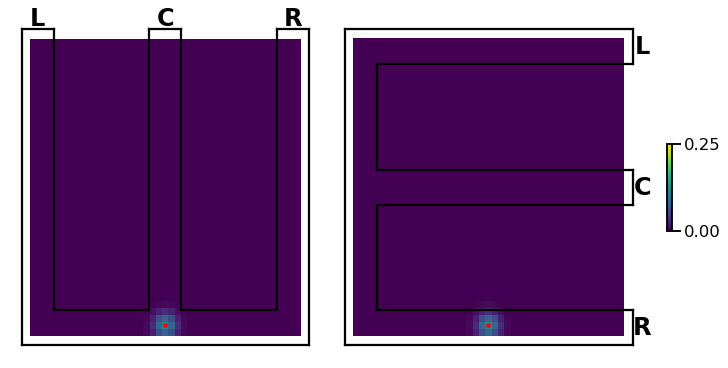

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for env_ind, (ax, env) in enumerate(zip(axes.flat, classifier3.environments)):
    mask = ~env.is_track_interior_
    mask = mask.astype(float)
    mask[mask == 1] = np.nan
    mask[mask == 0] = 1

    bin_ind = 64
    state_transition = (
        classifier3
        .continuous_state_transition_[env_ind, env_ind, bin_ind]
        .reshape(env.centers_shape_, order='F'))

    mesh = ax.pcolormesh(env.edges_[0],
                  env.edges_[1],
                  state_transition.T * mask.T, vmin=0.0, vmax=0.25)
    ax.scatter(env.place_bin_centers_[bin_ind, 0],
               env.place_bin_centers_[bin_ind, 1], color='red', zorder=10, s=10)
    if env_ind == 0:
        plot_wtrack1_outline(ax=ax)
    else:
        plot_wtrack2_outline(ax=ax)

    ax.axis('off')

plt.colorbar(mappable=mesh, ax=ax, shrink=0.25, ticks=[0, 0.25])

In [17]:
def make_sequence(neuron_sequence, n_neurons=28, step=1):
    neuron_sequence = np.asarray(neuron_sequence)
    n_time = step * len(neuron_sequence)
    spike_time_ind = np.arange(0, n_time, step)
    spikes = np.zeros((n_time, n_neurons))
    
    spikes[(spike_time_ind, neuron_sequence)] = 1
    
    return spikes

In [13]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments2 = (
    Environment('wtrack1', dilate=False))

continuous_transition_types2 = [[RandomWalk('wtrack1', movement_var=6.0, use_diffusion=True), Uniform('wtrack1')],
                                [Uniform('wtrack1'),    Uniform('wtrack1')]]

classifier2 = SortedSpikesClassifier(
    environments=environments2,
    continuous_transition_types=continuous_transition_types2,
    sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
    sorted_spikes_algorithm_params={'block_size': None,
                                   'position_std': 6.0,
                                   'use_diffusion_distance': True}
)

classifier2.fit(
    position=position1,
    spikes=spikes1,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


  0%|          | 0/28 [00:00<?, ?it/s]

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0, use_diffusion=True),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)],
                                                    [Uniform(environment_name='wtrack1', environment2_name=None),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)]],
                       discrete_transition_typ...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='wtrack1', encoding_group=0),
                                           ObservationModel(environment_name='wtrack1', encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_a

In [14]:
def plot_one_env_results(results):
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 8 / 3), sharex=True)
    prob = (results
     .acausal_posterior
     .sum('position')
     .assign_coords(time=lambda ds: ds.time))
     
    prob.plot(x='time', hue='state', ax=ax, add_legend=False)
    
    ax.set_ylim((0, 1))
    ax.set_yticks((0, 1))
    ax.set_yticklabels((0, 1))
    ax.set_ylabel('Prob.')
    
    ax.set_xlim((results.time[0], results.time[-1]))
    ax.set_xticks((results.time[0], results.time[-1]))
    ax.set_xticklabels((int(results.time[0]), int(results.time[-1])))
    ax.set_xlabel('Time [ms]')
    
    ax.text(results.time[-1], prob.isel(time=-1, state=0), 'Cont.', color='#1f77b4', va='center', ha='left', fontsize=14)
    ax.text(results.time[-1], prob.isel(time=-1, state=1), 'Frag.', color='#ff7f0e', va='center', ha='left', fontsize=14)
    
    sns.despine(offset=5)

In [15]:
import copy
from cycler import cycler


def plot_replay_results(test_spikes, classifier, results):
    
    time = np.arange(test_spikes.shape[0])
    
    fig, axes = plt.subplots(
        5, 1, 
        constrained_layout=True, figsize=(5, 12), sharex=True,
        gridspec_kw={'height_ratios':[1, 1, 0.5, 1, 1]})
    
    mask1 = ~classifier.environments[0].is_track_interior_
    mask1 = mask1.astype(float)
    mask1[mask1 == 1] = np.nan
    mask1[mask1 == 0] = 1
    mask1 = mask1[:, np.newaxis]

    mask2 = ~classifier.environments[1].is_track_interior_
    mask2 = mask2.astype(float)
    mask2[mask2 == 1] = np.nan
    mask2[mask2 == 0] = 1
    mask2 = mask2[:, np.newaxis]
    
    w_track1_cmap = copy.copy(plt.cm.get_cmap('Greens'))
    w_track1_cmap.set_bad(color="lightgrey", alpha=0.8)
    
    w_track2_cmap = copy.copy(plt.cm.get_cmap('Purples'))
    w_track2_cmap.set_bad(color="lightgrey", alpha=0.8)
    
    time_ind, cell_ind = np.nonzero(test_spikes)
    
    # Spikes sorted according to w-track 1 place fields
    w_track1_sort_order = np.argsort(np.asarray(
        get_linearized_position(place_field_centers1,
                                track_graph1,
                                edge_order=edge_order,
                                edge_spacing=edge_spacing,
                                use_HMM=False).linear_position))
    w_track1_sort_order = {cell_id: order for order, cell_id in enumerate(w_track1_sort_order)}
    

    axes[0].scatter(time[time_ind], [w_track1_sort_order[i] for i in cell_ind], clip_on=False, color='green', s=100, marker='|')
    axes[0].set_ylim((1, 28))
    axes[0].set_yticks((0, 28))
    axes[0].set_yticklabels((1, 29))
    axes[0].set_ylabel('Cells')
    axes[0].set_title('Ordered by Env. 1 Place Fields')
    
    # Spikes sorted according to w-track 2 place fields
    w_track2_sort_order = np.argsort(np.asarray(get_linearized_position(place_field_centers2,
                 track_graph2,
                 edge_order=edge_order,
                 edge_spacing=edge_spacing,
                 use_HMM=False).linear_position))
    w_track2_sort_order = {cell_id: order for order, cell_id in enumerate(w_track2_sort_order)}

    axes[1].scatter(time[time_ind], [w_track2_sort_order[i] for i in cell_ind], clip_on=False, color='purple', s=100, marker='|')
    axes[1].set_ylim((1, 28))
    axes[1].set_yticks((0, 28))
    axes[1].set_yticklabels((1, 29))
    axes[1].set_ylabel('Cells')
    axes[1].set_title('Ordered by Env. 2 Place Fields')
    
    # W-Track 1 posterior
    t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[0].edges_[0])
    axes[2].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
                       cmap=w_track1_cmap, vmin=0.0, vmax=0.1)
    axes[2].set_ylim((0, int(x.max())))
    axes[2].set_yticks((0, int(x.max())))
    axes[2].set_yticklabels((0, int(x.max())))

    axes[2].set_title('Prob. of Env. 1 Position')
    axes[2].set_ylabel('Position')
    
    arm_node_positions = np.asarray(
        get_linearized_position(np.asarray([track_graph1.nodes[node_id]['pos'] for node_id in [3, 0, 5]]),
                         track_graph1,
                         edge_order=edge_order,
                         edge_spacing=edge_spacing,
                         use_HMM=False).linear_position)
    for arm_label, arm_pos in zip(['L', 'C', 'R'], arm_node_positions):
        va = 'bottom' if arm_label == 'C' else 'top'
        axes[2].text(time[-1] + 1/1000, arm_pos, arm_label, va=va, ha='left', fontweight='bold')
    
    # Env. 2 posterior
    t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[1].edges_[0])
    n_position_bins = classifier.environments[1].is_track_interior_.shape[0]
    axes[3].pcolormesh(t, x, results['acausal_posterior'][:, 1, :n_position_bins].T * mask2,
                       cmap=w_track2_cmap, vmin=0.0, vmax=0.1)
    axes[3].set_title('Prob. of Env. 2 Position')
    axes[3].set_ylim((0, int(x.max())))
    axes[3].set_yticks((0, int(x.max())))
    axes[3].set_yticklabels((0, int(x.max())))
    axes[3].set_ylabel('Position') 
    arm_node_positions = np.asarray(
        get_linearized_position(np.asarray([track_graph2.nodes[node_id]['pos'] for node_id in [3, 0, 5]]),
                         track_graph2,
                         edge_order=edge_order,
                         edge_spacing=edge_spacing,
                         use_HMM=False).linear_position)
    for arm_label, arm_pos in zip(['L', 'C', 'R'], arm_node_positions):
        va = 'bottom' if arm_label == 'C' else 'top'
        axes[3].text(time[-1] + 1/1000, arm_pos, arm_label, va=va, ha='left', fontweight='bold')
    
    # Probabilities
    axes[4].set_prop_cycle(cycler(color=['green', 'purple']))
    prob = results['acausal_posterior'].sum(axis=2)
    axes[4].plot(time, results['acausal_posterior'].sum(axis=2),
                 label=['Env. 1', 'Env. 2'], clip_on=False,
                 linewidth=2
                )
    axes[4].text(time[-1], prob.isel(time=-1, state=0), 'Env. 1', color='green', va='center', ha='left', fontsize=14)
    axes[4].text(time[-1], prob.isel(time=-1, state=1), 'Env. 2', color='purple', va='center', ha='left', fontsize=14)
    axes[4].set_ylim((0, 1))
    axes[4].set_yticks((0, 1))
    axes[4].set_yticklabels((0, 1))
    axes[4].set_ylabel('Prob.\nof Env.')
    
    
    axes[4].set_xlabel('Time [ms]')
    axes[4].set_xlim((time[0], time[-1]))
    axes[4].set_xticks((time[0], time[-1]))
    axes[4].set_xticklabels((time[0], time[-1]))
    sns.despine(offset=5)

In [18]:
sequence = [8, 11, 14, 17, 20, 23]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes, use_gpu=True)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'], use_gpu=True)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


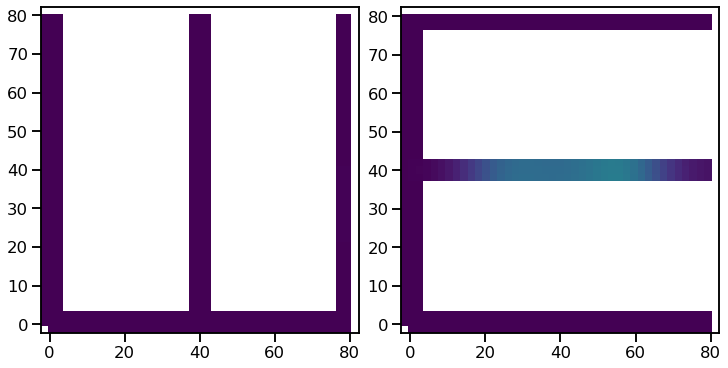

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for env_ind, (ax, env) in enumerate(zip(axes.flat, classifier.environments)):
    mask = ~env.is_track_interior_
    mask = mask.astype(float)
    mask[mask == 1] = np.nan
    mask[mask == 0] = 1
    summed_posterior = results.acausal_posterior.isel(state=env_ind).sum('time').values.reshape(env.centers_shape_, order='F')
    ax.pcolormesh(env.edges_[0],
                  env.edges_[1],
                  summed_posterior.T * mask.T,
                  vmin=0.0,
                  vmax=1.0)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


ValueError: operands could not be broadcast together with shapes (1849,30) (43,1,43) 

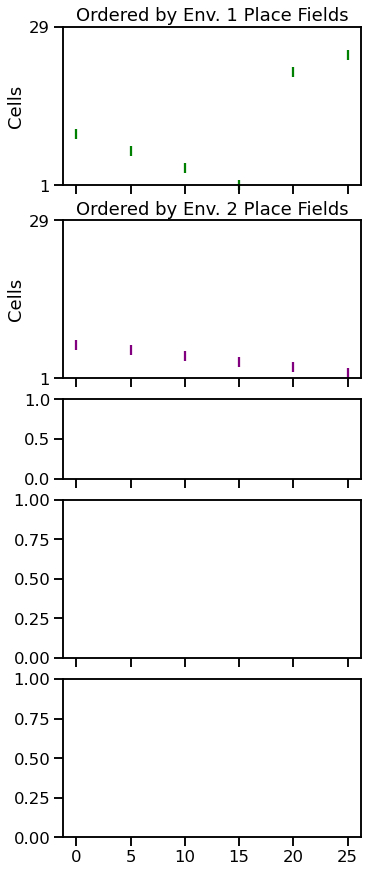

In [26]:
sequence = [8, 11, 14, 17, 20, 23]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
save_figure('replay_env2_alt')
plot_2D_place_field_sequence(sequence)
save_figure('replay_env2_field_sequence_alt')
plot_one_env_results(results2)
save_figure('replay_env2_one_env_alt')

In [ ]:
%debug

> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/variable.py(2467)_binary_op()
   2465         with np.errstate(all="ignore"):
   2466             new_data = (
-> 2467                 f(self_data, other_data) if not reflexive else f(other_data, self_data)
   2468             )
   2469         result = Variable(dims, new_data, attrs=attrs)



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/_typed_ops.py(402)__mul__()
    400 
    401     def __mul__(self, other):
--> 402         return self._binary_op(other, operator.mul)
    403 
    404     def __pow__(self, other):



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/dataarray.py(3098)_binary_op()
   3096 
   3097         variable = (
-> 3098             f(self.variable, other_variable)
   3099             if not reflexive
   3100             else f(other_variable, self.variable)



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/_typed_ops.py(212)__mul__()
    210 
    211     def __mul__(self, other):
--> 212         return self._binary_op(other, operator.mul)
    213 
    214     def __pow__(self, other):



ipdb>  u


> /tmp/ipykernel_177013/2762103290.py(68)plot_replay_results()
     66     # W-Track 1 posterior
     67     t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[0].edges_[0])
---> 68     axes[2].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
     69                        cmap=w_track1_cmap, vmin=0.0, vmax=0.1)
     70     axes[2].set_ylim((0, int(x.max())))



ipdb>  results['acausal_posterior'][:, 0].shape


(30, 1849)


ipdb>  mask1.shape


(43, 1, 43)


ipdb>  classifier.environments[0]


Environment(environment_name='wtrack1', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=True)


ipdb>  classifier.environments[0].place_bin_centers_


array([[-1.3750349 , -1.34859898],
       [ 0.59477131, -1.34859898],
       [ 2.56457752, -1.34859898],
       ...,
       [77.41721347, 81.22720204],
       [79.38701968, 81.22720204],
       [81.35682589, 81.22720204]])


ipdb>  classifier.environments[0].place_bin_centers_.shape


(1849, 2)


INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


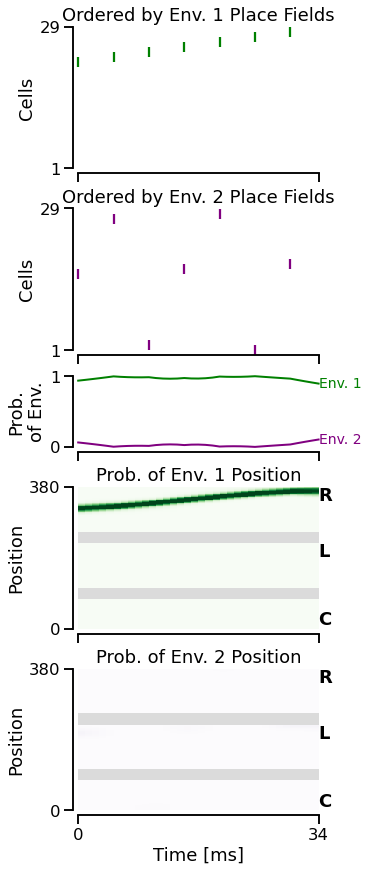

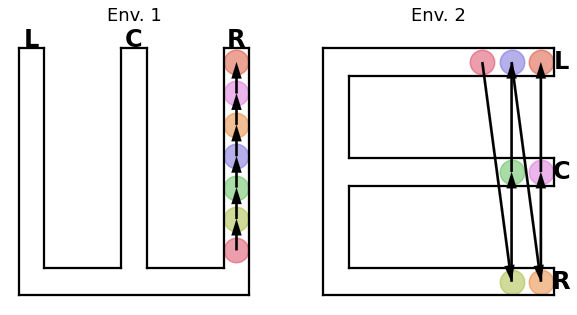

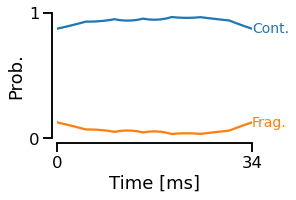

In [20]:
sequence = [21, 22, 23, 24, 25, 26, 27]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
save_figure('replay_env1_alt')
plot_2D_place_field_sequence(sequence)
save_figure('replay_env1_field_sequence_alt')
plot_one_env_results(results2)
save_figure('replay_env1_one_env_alt')

In [28]:
%debug

> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/variable.py(2467)_binary_op()
   2465         with np.errstate(all="ignore"):
   2466             new_data = (
-> 2467                 f(self_data, other_data) if not reflexive else f(other_data, self_data)
   2468             )
   2469         result = Variable(dims, new_data, attrs=attrs)



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/_typed_ops.py(402)__mul__()
    400 
    401     def __mul__(self, other):
--> 402         return self._binary_op(other, operator.mul)
    403 
    404     def __pow__(self, other):



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/dataarray.py(3098)_binary_op()
   3096 
   3097         variable = (
-> 3098             f(self.variable, other_variable)
   3099             if not reflexive
   3100             else f(other_variable, self.variable)



ipdb>  u


> /home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/xarray/core/_typed_ops.py(212)__mul__()
    210 
    211     def __mul__(self, other):
--> 212         return self._binary_op(other, operator.mul)
    213 
    214     def __pow__(self, other):



ipdb>  u


> /tmp/ipykernel_247859/2762103290.py(68)plot_replay_results()
     66     # W-Track 1 posterior
     67     t, x = np.meshgrid(np.append(time, time[-1] + 1/1000), classifier.environments[0].edges_[0])
---> 68     axes[2].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
     69                        cmap=w_track1_cmap, vmin=0.0, vmax=0.1)
     70     axes[2].set_ylim((0, int(x.max())))



ipdb>  mask1.shape


(43, 1, 43)


ipdb>  results['acausal_posterior'][:, 0].T.shape


(1849, 30)


ipdb>  ll


      5 def plot_replay_results(test_spikes, classifier, results):
      6 
      7     time = np.arange(test_spikes.shape[0])
      8 
      9     fig, axes = plt.subplots(
     10         5, 1,
     11         constrained_layout=True, figsize=(5, 12), sharex=True,
     12         gridspec_kw={'height_ratios':[1, 1, 0.5, 1, 1]})
     13 
     14     mask1 = ~classifier.environments[0].is_track_interior_
     15     mask1 = mask1.astype(float)
     16     mask1[mask1 == 1] = np.nan
     17     mask1[mask1 == 0] = 1
     18     mask1 = mask1[:, np.newaxis]
     19 
     20     mask2 = ~classifier.environments[1].is_track_interior_
     21     mask2 = mask2.astype(float)
     22     mask2[mask2 == 1] = np.nan
     23     mask2[mask2 == 0] = 1
     24     mask2 = mask2[:, np.newaxis]
     25 
     26     w_track1_cmap = copy.copy(plt.cm.get_cmap('Greens'))
     27     w_track1_cmap.set_bad(color="lightgrey", alpha=0.8)
     28 
     29     w_track2_cmap = copy.copy(plt.cm.get_cmap('Purple

ipdb>  spikes.shape


(399880, 28)


ipdb>  time.shape


(30,)


ipdb>  results['acausal_posterior'][:, 0].T.shape


(1849, 30)


ipdb>  classifier.environments[0].is_track_interior_.shape


(43, 43)


ipdb>  q


INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


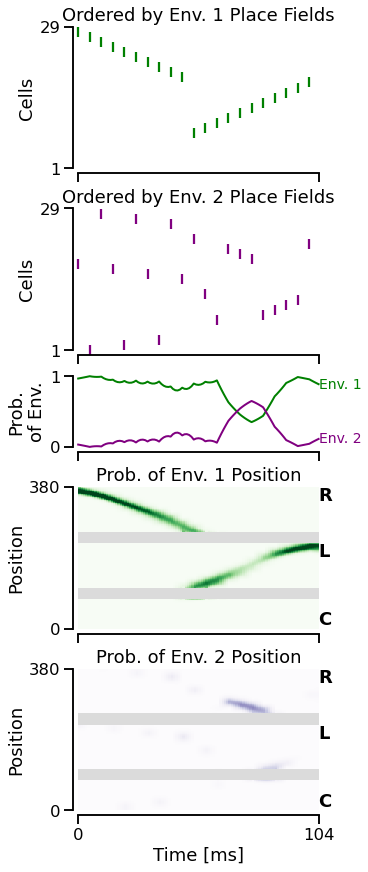

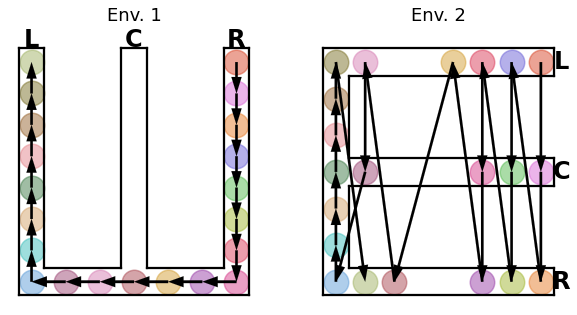

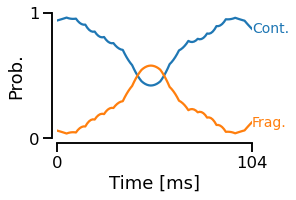

In [21]:
sequence = [27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 10, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


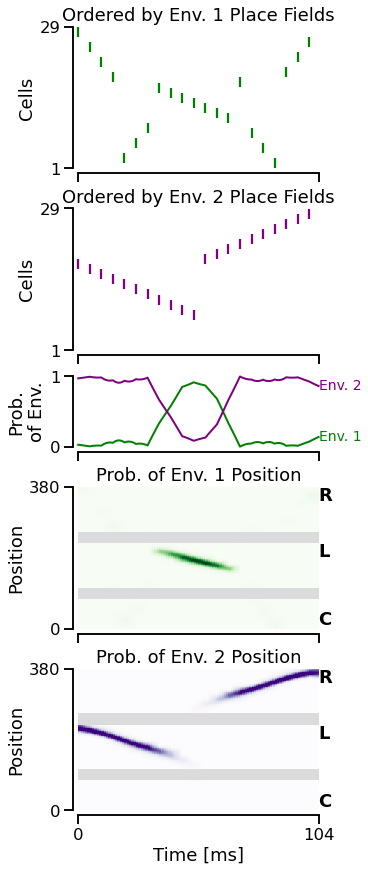

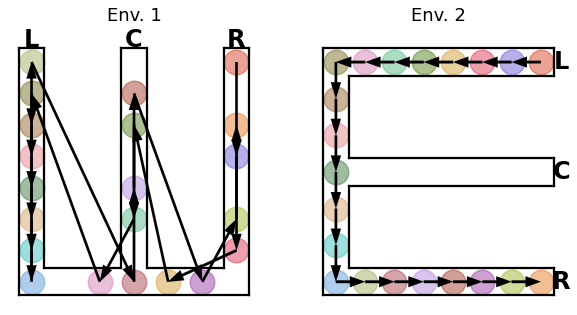

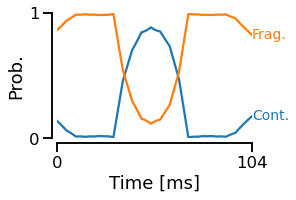

In [22]:
sequence = [27, 24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


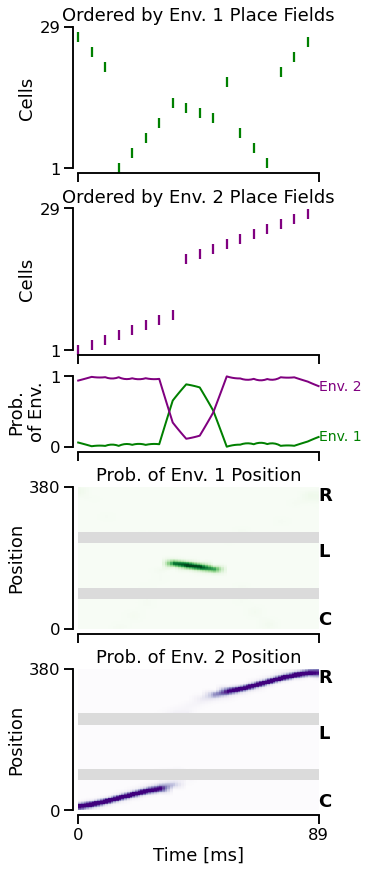

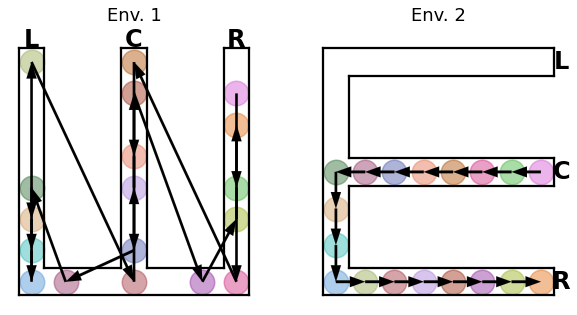

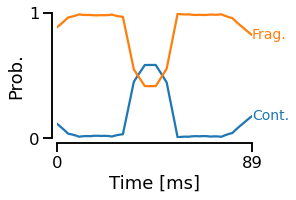

In [23]:
sequence = [26, 23, 20, 17, 14, 11, 8, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


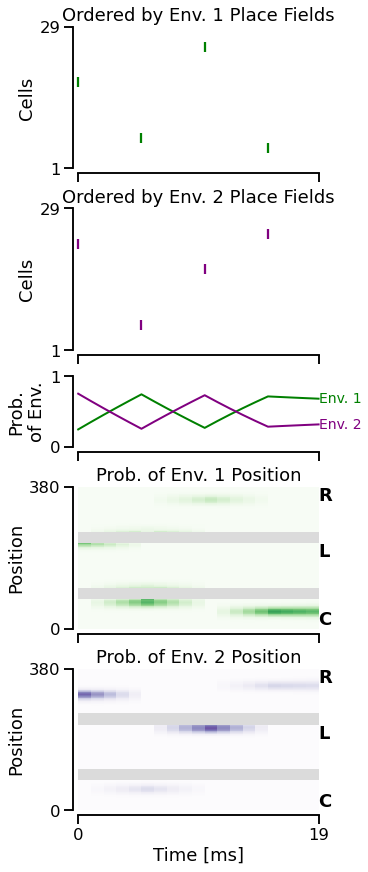

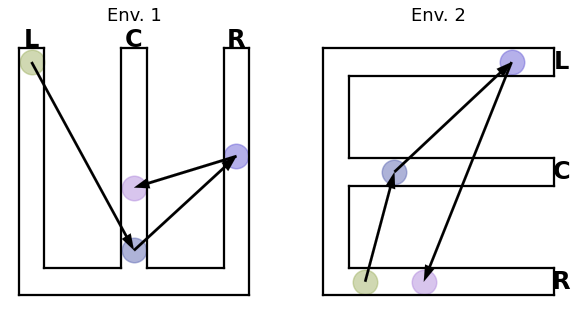

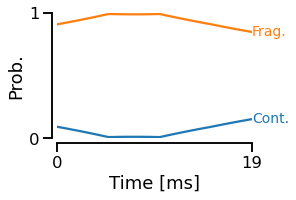

In [24]:
sequence = [7, 11, 24, 13]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
save_figure('replay_no_env_alt')
plot_2D_place_field_sequence(sequence)
save_figure('replay_no_env_field_sequence_alt')
plot_one_env_results(results2)
save_figure('replay_no_env_one_env_alt')

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


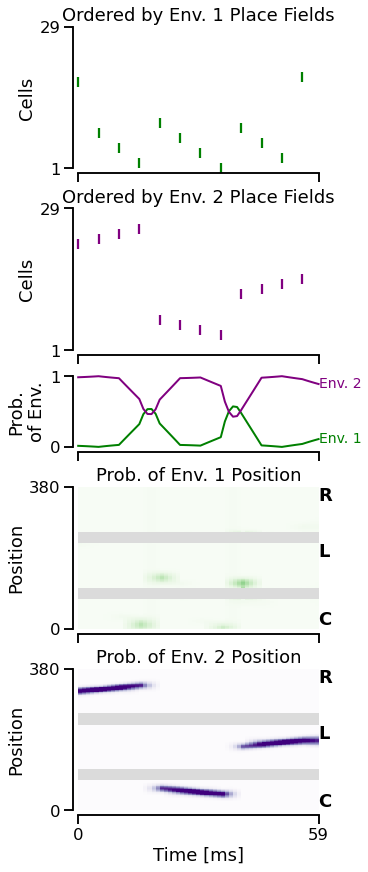

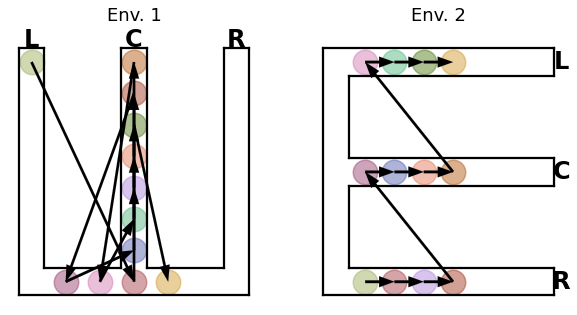

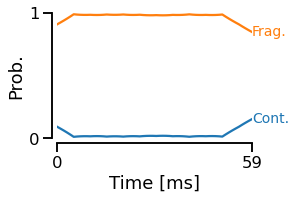

In [25]:
sequence = [7, 10, 13, 16, 8, 11, 14, 17, 9, 12, 15, 18]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/28 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


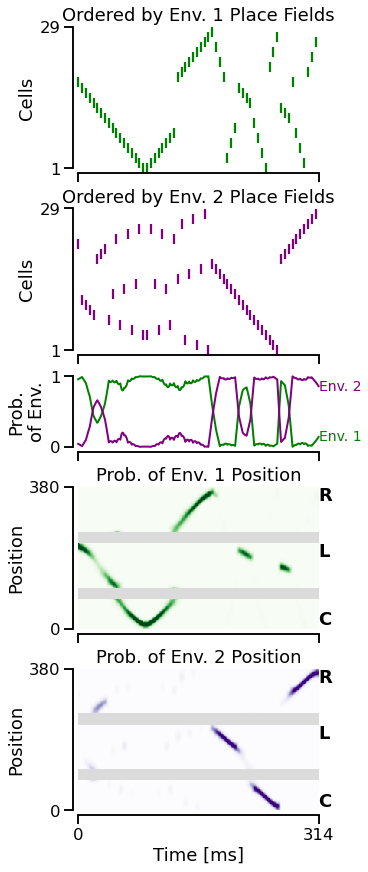

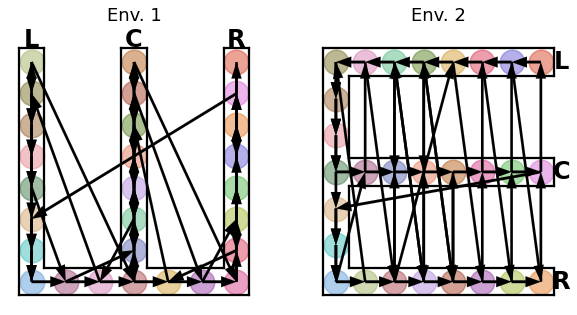

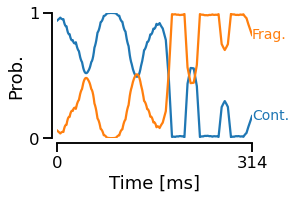

In [26]:
sequence = [7, 6, 5, 4, 3, 2, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
            17, 16, 15, 14, 13, 12, 11, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
            24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 8, 11, 14, 17, 20, 23, 26, 2, 1, 0,
            7, 10, 13, 16, 19, 22, 25]
test_spikes = make_sequence(sequence, 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_2D_place_field_sequence(sequence)
plot_one_env_results(results2)